In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

Using TensorFlow backend.


In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [3]:
#runs = [302634, 302635, 305814, 306121, 306122, 306125, 306126]
runs = [306121, 306122, 306125, 306126]
lumi_directory = data_directory = "./lumi"
rates_directory = "./rates"

Reading instantaneous luminosities from the cvs file produced with brilcalc and saving into a pandas dataframe:

In [4]:
df_rates = pd.DataFrame()
int_lumi2 = pd.DataFrame()
for run in runs:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"]), 
        ignore_index=True);    
    path = "%s/dt_rates_%s.csv" % (rates_directory, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True);
print("Done.")

Loading 306121
Loading 306122
Loading 306125
Loading 306126
Done.


Dropping useless rows from the dataframe:

In [5]:
int_lumi2["source"] = int_lumi2["source"].astype('str')
int_lumi2 = int_lumi2[int_lumi2["source"] != "nan"]
int_lumi2 = int_lumi2[int_lumi2["source"] != "source"]

Splitting run:fill and the start and end luminosities:

In [6]:
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['runfill'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

Converting run to integer and luminosities to float:

In [7]:
int_lumi2["run"] = int_lumi2["run"].astype('int')
int_lumi2["ls_start"] = int_lumi2["ls_start"].astype('int')
int_lumi2["ls_end"] = int_lumi2["ls_end"].astype('int')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

Converting time stamp to datetime:

In [8]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

Creating end time column from the start time:

In [9]:
int_lumi2["time_end"] = int_lumi2["time"]

Finding the runs and their start and end times:

In [10]:
boundaries = pd.DataFrame(columns=["run", "start", "end", "ls_start", "ls_end", "nLS"])
for i in runs:
    start = int_lumi2[int_lumi2["run"] == i]["time"]
    end = int_lumi2[int_lumi2["run"] == i]["time_end"]
    start_ls = int_lumi2[int_lumi2["run"] == i]["ls_start"]
    end_ls = int_lumi2[int_lumi2["run"] == i]["ls_end"]
    start =  start.reset_index(drop=True)
    end =  end.reset_index(drop=True)
    start_ls =  start_ls.reset_index(drop=True)
    end_ls =  end_ls.reset_index(drop=True)
    nLS = int(start_ls.iloc[-1]) - int(start_ls.iloc[0]) + 1
    print i, start.iloc[0], start.iloc[-1], start_ls.iloc[0], start_ls.iloc[-1], nLS
    boundaries = boundaries.append({"run": i, "start": start.iloc[0], "end": start.iloc[-1], 
                                   "ls_start": start_ls.iloc[0], "ls_end": start_ls.iloc[-1], "nLS": nLS}, 
                                   ignore_index = True)

306121 2017-11-03 13:10:09 2017-11-03 13:52:52 42 152 111
306122 2017-11-03 13:53:18 2017-11-03 14:46:08 1 137 137
306125 2017-11-03 14:46:12 2017-11-04 10:14:06 1 3007 3007
306126 2017-11-04 10:14:24 2017-11-04 13:28:39 1 501 501


Reindexing the dataframe after removing some lines:

In [11]:
int_lumi2.index = pd.RangeIndex(len(int_lumi2.index))

In [12]:
print len(int_lumi2.index)

3756


In [13]:
def addTimeOffSet(startdate):
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

def shiftElement(df, boundaries):
    run0 = boundaries["run"].iloc[0]
    for index, rows in df.iterrows():
        run = rows["run"]
        nls = int(boundaries[boundaries["run"] == run]["nLS"])
        if(run > run0):
            nls = nls + index
        #print run, nls
        if((index < nls) & (index < len(int_lumi2.index)-1)):
            #print index, run, rows["time"], df["time"][index+1]
            df.loc[index, "time_end"] = df["time"][index+1]
        elif (index == len(int_lumi2.index)-1):
            #print index, run, rows["time"], addTimeOffSet(rows["time"])
            df.loc[index, "time_end"] = addTimeOffSet(rows["time"])
                    
shiftElement(int_lumi2, boundaries)

In [14]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Inst. Lumi. [E30 Hz/cm$^2$]")
    xfmt = mdates.DateFormatter('%y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

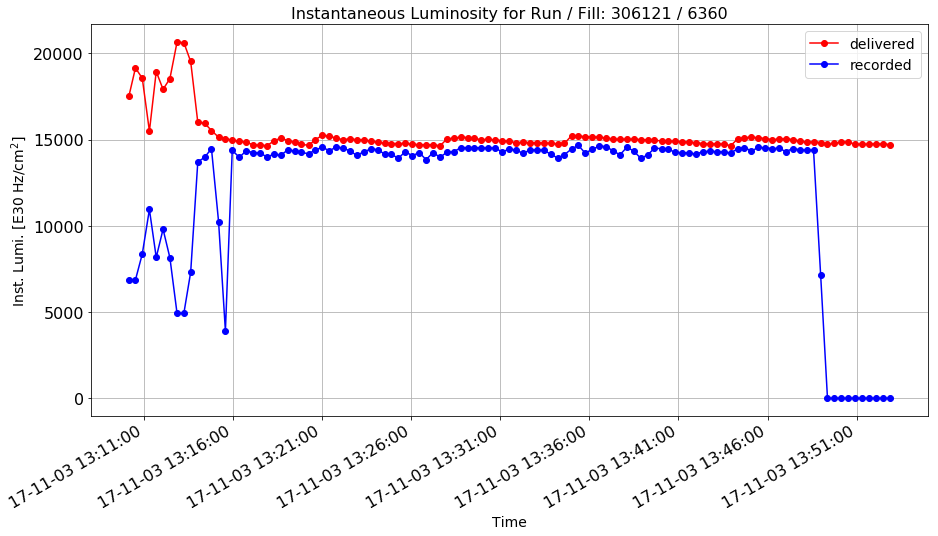

In [15]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306121]["time"], 
               int_lumi2[int_lumi2["run"] == 306121]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306121]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[0], int_lumi2["fill"].iloc[0])))

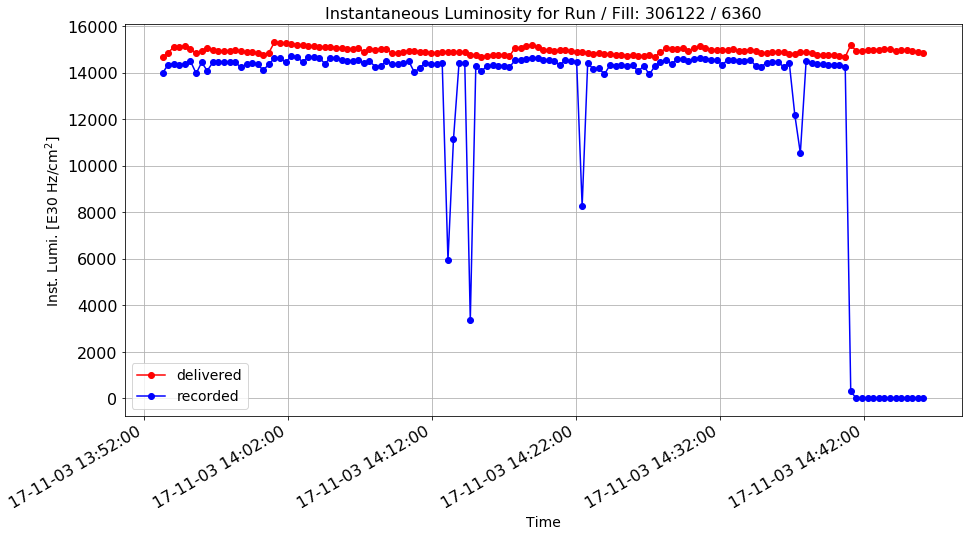

In [16]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306122]["time"], 
               int_lumi2[int_lumi2["run"] == 306122]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306122]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[1], int_lumi2["fill"].iloc[0])))

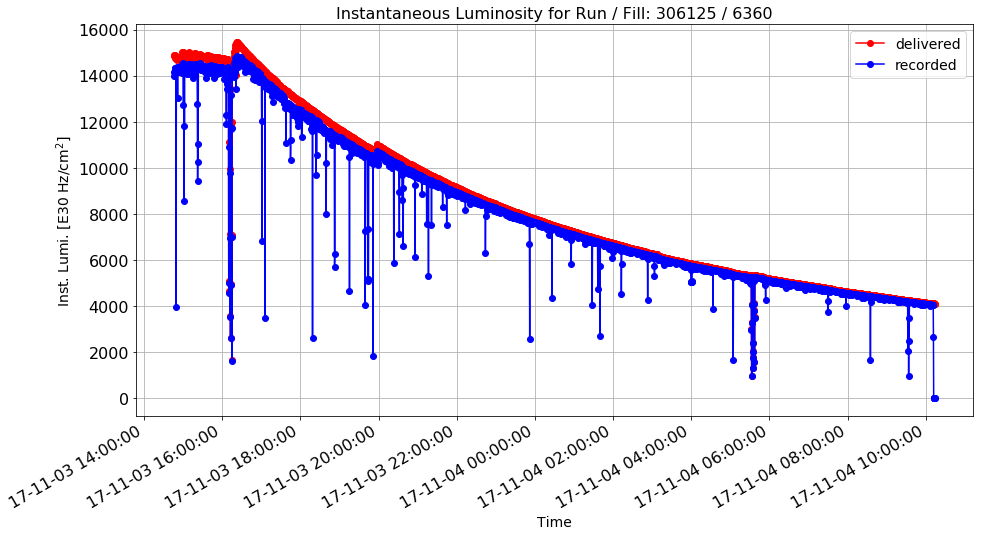

In [17]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306125]["time"], 
               int_lumi2[int_lumi2["run"] == 306125]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306125]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[2], int_lumi2["fill"].iloc[0])))

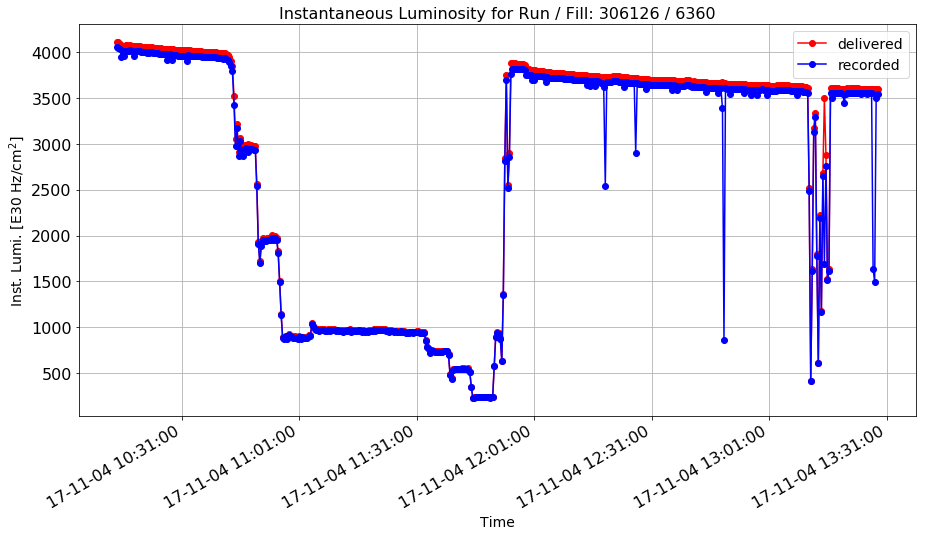

In [18]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306126]["time"], 
               int_lumi2[int_lumi2["run"] == 306126]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306126]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[3], int_lumi2["fill"].iloc[0])))

In [19]:
int_lumi2.to_csv("int_lumi2.csv", sep='\t')

Reading rates from the cvs files produced by the script and saving the informations into a new pandas dataframe:

In [20]:
df_rates["time"] = pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
#print df_rates["time"]

Converting and splitting:

In [21]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

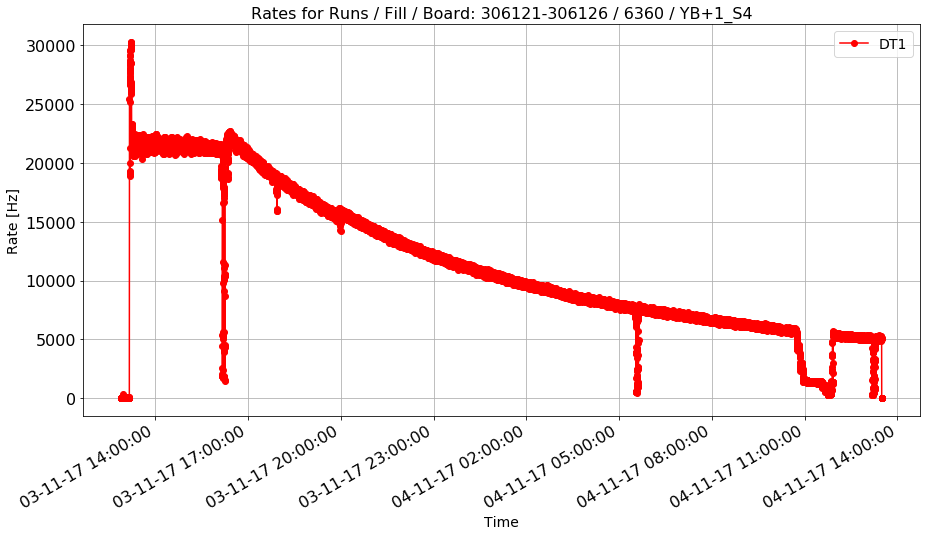

In [22]:
def plot_rate_vs_time(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

plot_rate_vs_time(df_rates, "time", "DT1", "YB+1_S4", "Rates for Runs / Fill / Board: %s / %s / %s" % 
                  (str(boundaries["run"].iloc[0])+"-"+str(boundaries["run"].iloc[3]), 
                   int_lumi2["fill"].iloc[2], "YB+1_S4"))

In [23]:
df_rates["ls"] = -1
df_rates["start"] = -1
df_rates["end"] = -1
df_rates["lumi"] = -1.0
df_rates["score"] = -1
df_rates["errorRPC1"] = -1.0
df_rates["errorRPC2"] = -1.0
df_rates["errorRPC3"] = -1.0
df_rates["errorRPC4"] = -1.0
df_rates["errorDT1"] = -1.0
df_rates["errorDT2"] = -1.0
df_rates["errorDT3"] = -1.0
df_rates["errorDT4"] = -1.0
df_rates["errorDT5"] = -1.0
#print df_rates["ls"]

Associating a LS to each rate:

In [24]:
df_rates_backup = df_rates.copy()

In [25]:
#df_rates = df_rates_backup

In [41]:
time0 = boundaries["start"].iloc[0]
timeF = boundaries["start"].iloc[-1]
#print time0, timeF
#print df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
df_rates = df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
rule = df_rates.duplicated(subset=["time"])
count = (rule == False).sum()
print "Duplicates:", rule.sum()
df_rates_noduplicates = df_rates[rule == False]
#print df_rates_noduplicates

Duplicates: 1378181


In [42]:
print len(df_rates_noduplicates)

23359


In [63]:
def assignLS(df1, df2, boundaries):
    j = 1
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        time1 = row1["time"]
        #print index1, run1, time1
        ti = time1 - 2*pd.DateOffset(seconds=23)
        tf = time1 + 2*pd.DateOffset(seconds=23)
        indexes2 = df2[(df2.run == run1) & (df2.time > ti) & (df2.time < tf)].index
        #print indexes2
        for i in indexes2:
            if((time1 >= df2["time"].loc[i]) & (time1 < df2["time_end"].loc[i])):
                #print time1, df2["time"].loc[i], df2["time_end"].loc[i]
                if(j%100 == 0): 
                    print j
                j = j + 1
                ls = df2["ls_start"].loc[i]
                lumi = df2["delivered"].loc[i]
                #print index1, run1, time1, ls, lumi
                df1.loc[index1, "ls"] = ls
                df1.loc[index1, "lumi"] = lumi
                break

assignLS(df_rates_noduplicates, int_lumi2, boundaries)

In [60]:
df_rates_noduplicates = df_rates_noduplicates[df_rates_noduplicates["ls"] > 0]
#print df_rates_noduplicates[df_rates_noduplicates["ls"] == -1]
#print df_rates_noduplicates.loc[18600]

In [71]:
df_rates.to_csv("df_rates.csv", sep='\t')
df_rates_noduplicates.to_csv("df_rates_nodup.csv", sep='\t')

In [ ]:
def assignLS(df1, df2):
    for index1 in range(df1.index[0], df1.index[-1], 60):
        #print index1
        time = df1.time.loc[index1]
        red = df2[df2["time"] == time]
        if(len(red) > 0):
            ls = red["ls"].iloc[0]
            lumi = red["lumi"].iloc[0]
            for i in range(index1, index1+60):
                #print i, time, ls, lumi
                df1.loc[i, "ls"] = ls
                df1.loc[i, "lumi"] = lumi   
    
assignLS(df_rates, df_rates_noduplicates)

Averaging the rates associated to the same LS:

In [ ]:
df_rates = df_rates[df_rates.ls > 0]
#print df_rates

In [ ]:
#print df_rates[df_rates["DT1"] < 100]["DT1"]

In [ ]:
df_boards = df_rates["board"]
df_boards = df_boards[df_boards.duplicated() == False]
#print df_boards

In [ ]:
#print df_rates[(df_rates["run"] == 306125) & (df_rates["ls"] == 1041) & (df_rates["board"] == "YB0_S2")]

In [ ]:
#algos = ["RPC1", "RPC2", "RPC3", "RPC4","DT1", "DT2", "DT3", "DT4", "DT5"]
algos = ["DT1", "DT2", "DT3", "DT4", "DT5"]
resultAverage2 = []
for board in df_boards:
    #print board
    for run in runs:
        rate = df_rates[(df_rates["board"] == board) &(df_rates["run"] == run)]
        rule = rate.duplicated(subset=["run", "wheel", "sector", "ls"])
        count = (rule == False).sum() #Number of non duplicated objects = Number of LS
        #print "nLS:", count
        for i in range(1,count+1): #Loop over the LS
            #print i
            average = [] #List of average rates for each algos
            std_dev = [] #List of uncertainties for each algos
            index0 = -1 #Index of the first duplicate
            #print rate[rate["ls"] == i]
            rate2 = rate[rate["ls"] == i] #Duplicates with the same LS
            for x in algos:
                #print run, i, x, rate2[x]
                std = round(rate2[x].std(), 1)
                mean = round(rate2[x].mean(), 1)
                indexes = rate2[x].index
                if (len(indexes) == 0):
                    #print run, i, x, rate2[x]
                    continue
                index0 = indexes[0]
                #print index0, mean, std, rate2[x].count(), std/rate2[x].count()
                average.append(mean)
                std_dev.append(std/rate2[x].count())
            #print average, std_dev
            resultAverage2.append([i, index0, average, std_dev])
        #print resultAverage2

In [ ]:
print len(resultAverage2)

Removing the duplicates:

In [ ]:
df_rates_backup = df_rates.copy()

In [ ]:
rule = df_rates.duplicated(subset=["run", "wheel", "sector", "ls"])
print "Duplicates:", rule.sum()
df_rates = df_rates[rule == False]

Assigning the average rates previously calculated to the remaining rows:

In [ ]:
#0: ls, 1: index0, 2: average rates, 3: uncertanties
for obj in resultAverage2:
    #print obj[0], obj[1], obj[2], obj[3]
    if (len(obj[2]) == 0):
        continue
    index = obj[1]
    if index not in df_rates.index:
        continue
    for algo in algos:
        index_algo = algos.index(algo)
        #print obj[2][index_algo], obj[3][index_algo], str(algo)
        df_rates.loc[index, str(algo)] = obj[2][index_algo]
        df_rates.loc[index, "error"+str(algo)] = obj[3][index_algo]

In [ ]:
#Check one case
for index, row in df_rates.iterrows():
    if row["board"] == "YB0_S1":
        print "Index:", index,", Run:", row["run"],", Board: ",row["board"],", LS: ",row["ls"],", Algo rate: ",row["DT1"],", Error: ",row["errorDT1"]

Assigning the instantaneous luminosity to each rate:

In [ ]:
def assignRate(df1, df2):
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        ls1 = row1["ls"]
        for index2, row2 in df2.iterrows():
            run2 = row2["run"]
            ls2 = row1["ls"]
            #eventually add fill check
            if (run1 != run2):
                continue
            if (ls1 != ls2):
                continue
            df1.set_value(index1, 'start', row2["time"])
            df1.set_value(index1, 'end', row2["time_end"])
            df1.set_value(index1, 'lumi', row2["delivered"])
            break
assignRate(df_rates, int_lumi2)

In [ ]:
#print df_rates[df_rates["board"] == "YB0_S2"]["RPC1"]
#print df_rates[df_rates["board"] == "YB0_S1"]["RPC1"]

Plotting the result:

In [ ]:
def plot_rate_vs_ls(df, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], opt)
    plt.legend(loc="best")
    plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    plt.title(title)
    plt.show();

plot_rate_vs_ls(df_rates, "ls", "DT1", "YB+1_S4", 0, "errorDT1", "LS", "Rate [Hz]", "Rates for Run/Fill/Board "
                +int_lumi2["run:fill"][2]+":YB+1_S4", "ro-")
plot_rate_vs_ls(df_rates, "lumi", "DT1", "YB+1_S4", 0, "errorDT1", "Inst. Lumi. [E30 Hz/cm$^2$]", "Rate [Hz]", 
                "Rates for Run/Fill/Board "+int_lumi2["run:fill"][2]+":YB+1_S4", "ro")

In [ ]:
df_rates_new = pd.DataFrame(columns=["content","score"])
for index, row in df_rates.iterrows():
    for j in algos:
        #print j
        system = 0
        station = 0
        if (j.find("RPC") != -1):
            system = 1
        else:
            system = 2
        num = j.replace("RPC", "")
        num = num.replace("DT", "")
        station = int(num)
        array = np.array([system, row["wheel"], row["sector"], station, row[j], row["error"+j], row["lumi"]])
        #print array
        df_rates_new = df_rates_new.append({"content":array, "score":row["score"]}, ignore_index=True)

In [ ]:
#print df_rates_new

Creating train and test samples:

In [ ]:
# Set a random seed to reproduce the results
rng = np.random.RandomState(0)

anomalies = df_rates_new[df_rates_new.score == 1]
normalies = df_rates_new[df_rates_new.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train, test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

print("Number of anomalies in the train set: %s" % len(anomalies_test))
print("Number of normal in the train set: %s" % len(normalies_test))

In [ ]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])

        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o',
                 label="CNN working point")
    plt.title("ROC")
    plt.legend(loc='best')
    plt.ylabel('Sensitivity (TPR)')
    plt.xlabel('Fall-out (TNR)')
    plt.show();

In [ ]:
sess = tf.Session()
K.set_session(sess)

In [ ]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0])
    return np.asarray([0, 1])

def nn_generate_input():  
    return (np.array(np.concatenate(neural_train.content.values)).reshape(-1, 7),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content.values)).reshape(-1, 7),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content.values)).reshape(-1, 7))

(train_x, train_y, val_x, val_y, test_x) = nn_generate_input()

Defining NN structure:

In [ ]:
def neural_network():
    model = Sequential()
    model.add(Reshape((7, 1), input_shape=(7,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(16, activation='relu', name="dense_ann"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

In [ ]:
ann = neural_network()
print("Neural Network Architecture:")
ann.summary()

Training the NN:

In [ ]:
# This may take some time...

def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer='Nadam')

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("./model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

In [ ]:
history_ann = train_nn(ann,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann",
                       validation_data=(val_x, val_y),
                       class_weight=None)

Making an inference using the model and the test sample:

In [ ]:
ann_model = load_model("./model_keras/ann.h5")
layers_test["ann_score"] = ann_model.predict(np.array(test_x))[:, 1]

In [ ]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity
    
#specificity_ann, sensitivity_ann = benchmark(layers_test["score"], layers_test["ann_score"], 0.5)

In [ ]:
#get_roc_curve(layers_test,
#               ("Neural Network", "ann_score"),
#              (specificity_ann, sensitivity_ann))